## **Environment Setup**
Run all when initiating session

In [ ]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/config.py' '.'
!mkdir data
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/data/' '.'
!mkdir models
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/models/' '.'
!mkdir technical
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/technical/' '.'
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/encoder_engineering/utils/' '.'

In [1]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [2]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

if isColab():
  gcs.init()
# no need of buckets for this project

## **Model Environment Setup**

In [3]:
### tf-side debug ###
# more info: https://github.com/tensorflow/tensorflow/issues/29931
import tensorflow as tf
temp = tf.zeros([2, 16, 16, 3])  # Or tf.zeros
tf.keras.applications.vgg16.preprocess_input(temp)
print('')

In [4]:
from data.pipeline import *
from technical.accelerators import strategy
from utils.generator_loading_utils import load_generator_checkpoint
from utils.encoder_loading_utils import load_encoder_checkpoint
from utils.face_utils import detect_and_crop_lips

Running on CPU
Number of accelerators (cores):  1


In [5]:
##### Create and load saved generator here (checkpoint) #####
# please put generator's saved checkpoint in OUTPUT/generator_checkpoints (GCS for colab)
RUN = True
if RUN:
  generator = load_generator_checkpoint(strategy)
  print(generator)
else:
  print("Running switch for this cell is off, skipping")

r.layer_with_weights-1.kernel


In [6]:
##### Create and load saved encoder here (checkpoint) #####
# please put encoder's saved checkpoint in OUTPUT/encoder_checkpoints (GCS for colab)
RUN = True
if RUN:
  encoder = load_encoder_checkpoint(strategy)
  print(encoder)
else:
  print("Running switch for this cell is off, skipping")

Model: "modified-vgg16-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 360, 360, 4)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 360, 360, 32)      1184      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 360, 360, 32)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 180, 180, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 90, 90, 

In [7]:
LATENT_SIZE = encoder.model.layers[-1].output.shape[1:] 
IMAGE_SHAPE = encoder.model.layers[0].output.shape[1:] 
IMAGE_SIZE = [IMAGE_SHAPE[0], IMAGE_SHAPE[0]]
print("Latent size: " + str(LATENT_SIZE))
print("Image shape: " + str(IMAGE_SHAPE))

Latent size: (256,)
Image shape: (360, 360, 4)


## **Testing**

In [8]:
import numpy as np
import os

In [25]:
## input
img_name = 'test_2.png'
img_path = os.path.join(DIR, os.path.join('samples', img_name))
img = load_image(img_path)

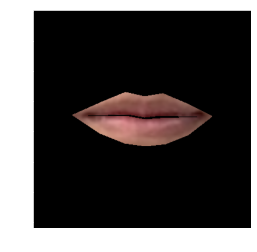

In [26]:
## crop
cropped_lips = np.array(detect_and_crop_lips(img_full=img))/255
plt.imshow(cropped_lips)

In [27]:
## Encode the cropped lips
encoded = encoder.model(np.expand_dims(cropped_lips, 0))
print(encoded)

tf.Tensor(
[[ 0.0045248   0.00567227 -0.15689328 -0.00106939 -0.0045947   0.0582777
  -0.0627269  -0.05724011 -0.04347571 -0.03226675  0.08453324  0.1066271
   0.10468148  0.06422119  0.03529591 -0.02825247 -0.05315616  0.02895559
   0.18408176  0.10685386  0.13399054  0.00409121 -0.05157537 -0.06743997
  -0.02837406  0.01380325 -0.01764171 -0.06066972 -0.0433033   0.12817296
   0.03579708 -0.01111856  0.04465263 -0.06723139  0.01034841 -0.00914403
   0.081921   -0.06150221 -0.06865343  0.13325343 -0.05778715  0.10352087
  -0.02164652 -0.13399455  0.05562659  0.08642751 -0.03959987  0.04815572
  -0.10965714 -0.02803451 -0.09521911 -0.11558007 -0.09913646 -0.00910604
  -0.02678538 -0.06630798 -0.0478006  -0.01894504  0.08283494  0.04217005
   0.05695645  0.07147422 -0.02963561  0.00591495  0.0600447  -0.00745433
  -0.06057294  0.13865429 -0.06303708  0.04311974  0.04287645 -0.06439571
   0.11138794  0.21122159  0.06237017 -0.0567448  -0.08718807 -0.02306717
  -0.13096644 -0.05159523  0.

Visual loss: 0.006391887087374926


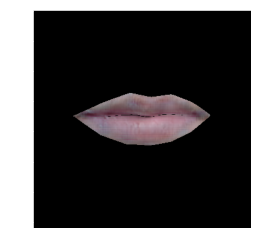

In [28]:
## Regeneration (w/o injections)
regenerated = generator.model(encoded, training=False)[0]
plt.imshow(regenerated)
print("Visual loss: " + str(float(tf.keras.losses.MSE(tf.keras.backend.flatten(cropped_lips), tf.keras.backend.flatten(regenerated)))))

In [ ]:
## TODO: Replacement

## **Experiments**
Just a playground for trying out codes, nothing related at all, do not execute